<a href="https://colab.research.google.com/github/febse/ts2025-presentations-2-radi-yuleto/blob/main/time_series_assignment2_radi_yulia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TS 2025 - Assignment 2

Before you begin, set the assignment seed to the student id of one of your team members in the cell below.
To choose the data for this set the assignment seed to the student id of one of the team members. The
cell is prefilled with an **example** student id, so make sure to change it and **run the cell** before proceeding
further.

In [ ]:
# NB!: change this to the student id of one of your team members

assignment_seed = "9EB0100111"

  
## Tasks

1. Run the following cell to load your data. It will be stored in the pandas Series `dt`. All time series
are stock prices from the SOFIX index. The data that you should use for the model selection is stored in the
series `train`. The data for testing the forecasts is stored in the series `test`.

2. Adjust the labels and titles of the plots to reflect the stock you are analyzing
3. Your task is to select an ARIMA model for the stock price.
   - Choose the order of differencing based on the ACF/PACF plots and unit root tests (ADF, KPSS)
   - Choose the AR and MA orders based on the ACF/PACF plots and information criteria (AIC, BIC)
4. After selecting the ARIMA model, analyze the residuals
   - Plot the residuals and their ACF/PACF
   - Perform the Ljung-Box test on the residuals
   - Plot the histogram and QQ-plot of the residuals
5. Analyze the volatility of the residuals using an appropriate plot
6. Fit several ARCH/GARCH models to the residuals
   - Plot the conditional volatility
   - Analyze the standardized residuals of the GARCH model (plots, Ljung-Box test, histogram, QQ-plot)
   - Test whether negative and positive shocks have different effects on volatility
  
7. Forecast the stock prices for the test period using the ARIMA model in two ways:
   - By manually differencing the data before fitting the ARIMA model
   - By using the integrated ARIMA model directly
   - Compare the forecasts from both methods and explain the differences, explain the meaning of an
     intercept in the ARIMA model with differenced data
   - Plot the forecasts along with the actual values
   - Compute the RMSE of the forecasts

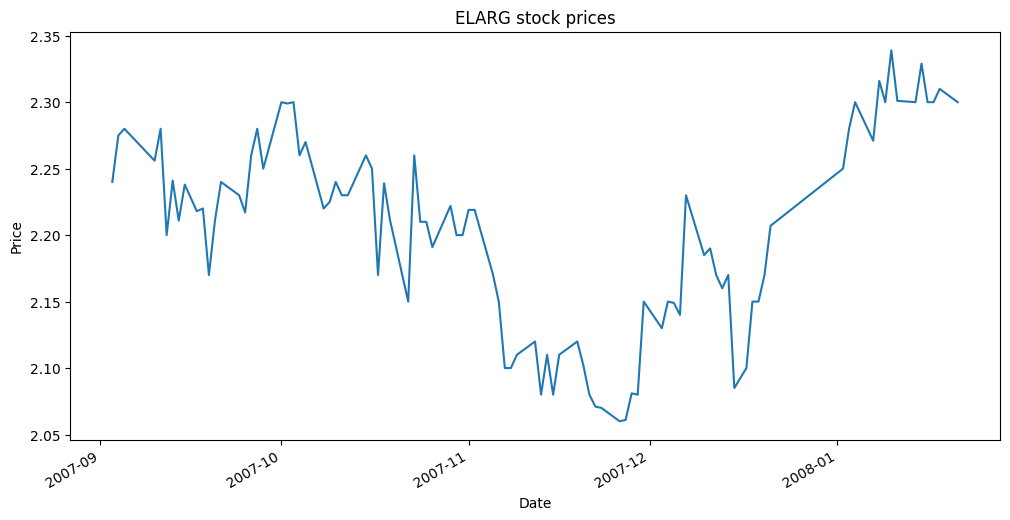

In [ ]:
# Import libraries

%pip install arch

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
import numpy as np

np.random.seed(int(re.sub(r"\D", "", assignment_seed)))

stocks = pd.read_excel("https://github.com/febse/data/raw/refs/heads/main/ts/SOFIX-Stocks.xlsx", usecols="A:Q").set_index("Date")

dt = stocks[np.random.choice(stocks.columns)]

# Split the data into training and test sets

train_size = int(len(dt) * 0.85)
train, test = dt[:train_size], dt[train_size:]

# Plot the training data

train.plot(title="Stock Price", figsize=(12, 6))

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("ELARG stock prices")
plt.show()

In [ ]:
train

,ELARG
Date,
2007-09-03,2.240
2007-09-04,2.275
2007-09-05,2.280
2007-09-10,2.256
2007-09-11,2.280
...,...
2008-01-15,2.329
2008-01-16,2.300
2008-01-17,2.300


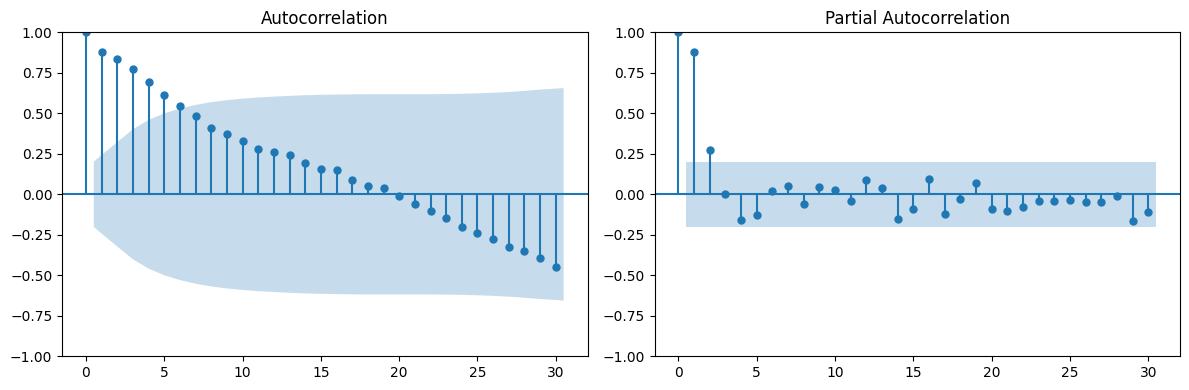

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fix, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train, ax=ax[0], lags=30)
plot_pacf(train, ax=ax[1], lags=30)
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(train)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.558610
p-value: 0.504345
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584


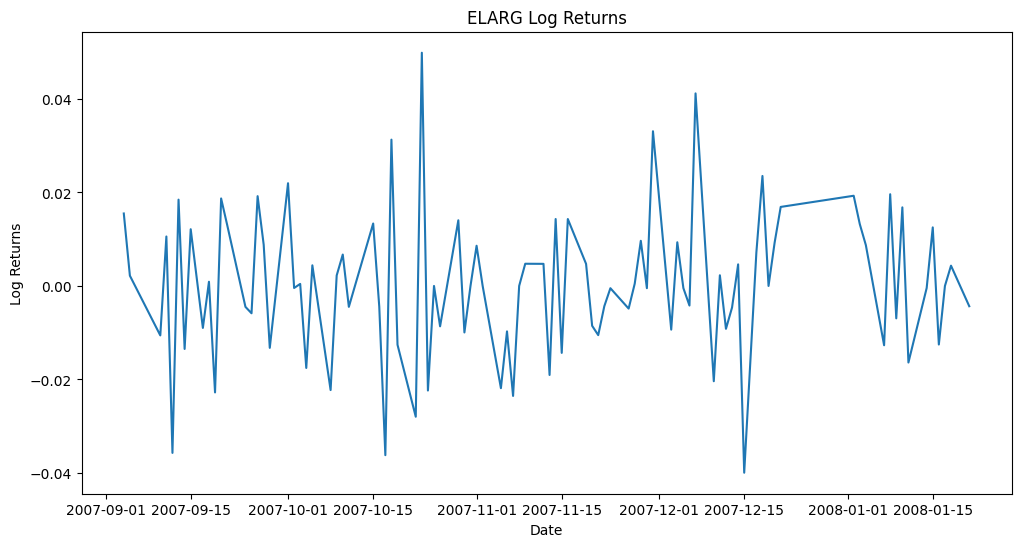

In [ ]:

train_lr = np.log(train).diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(train_lr)
plt.title('ELARG Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.show()

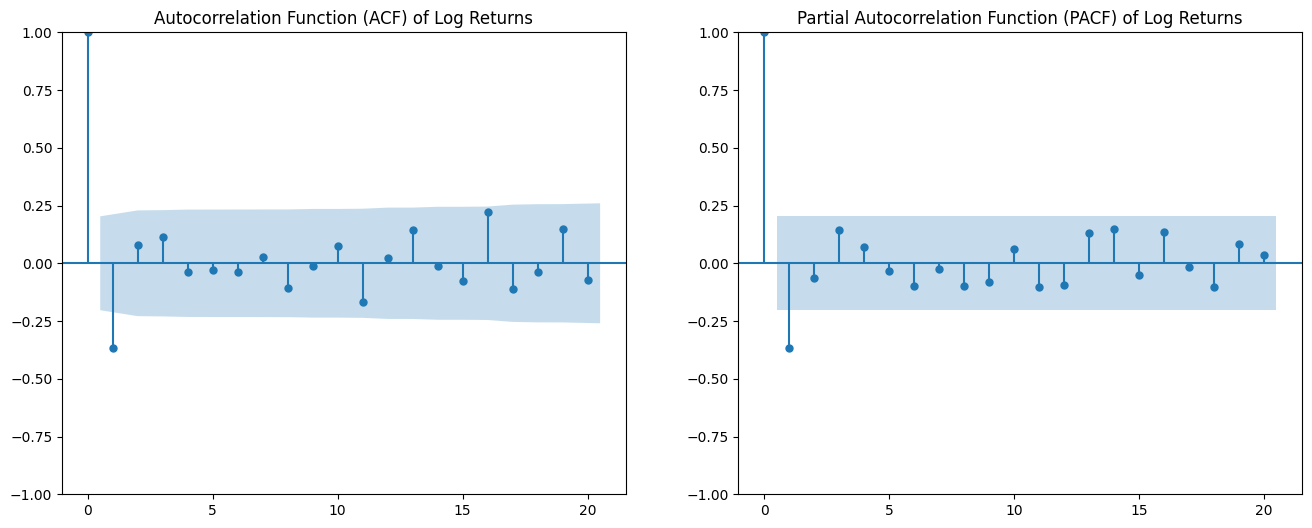

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(train_lr.dropna(), ax=axes[0], title='Autocorrelation Function (ACF) of Log Returns')
plot_pacf(train_lr.dropna(), ax=axes[1], title='Partial Autocorrelation Function (PACF) of Log Returns')

plt.show()

In [ ]:
adf_result_lr = adfuller(train_lr.dropna())

print('ADF Statistic: %f' % adf_result_lr[0])
print('p-value: %f' % adf_result_lr[1])
print('Critical Values:')
for key, value in adf_result_lr[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.014908
p-value: 0.000000
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


# ARIMA MODELS

                               SARIMAX Results                                
Dep. Variable:                  ELARG   No. Observations:                   94
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 260.577
Date:                Thu, 15 Jan 2026   AIC                           -517.154
Time:                        11:40:40   BIC                           -512.089
Sample:                             0   HQIC                          -515.109
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3666      0.113     -3.240      0.001      -0.588      -0.145
sigma2         0.0002   2.74e-05      7.854      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.05   Jarque-

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


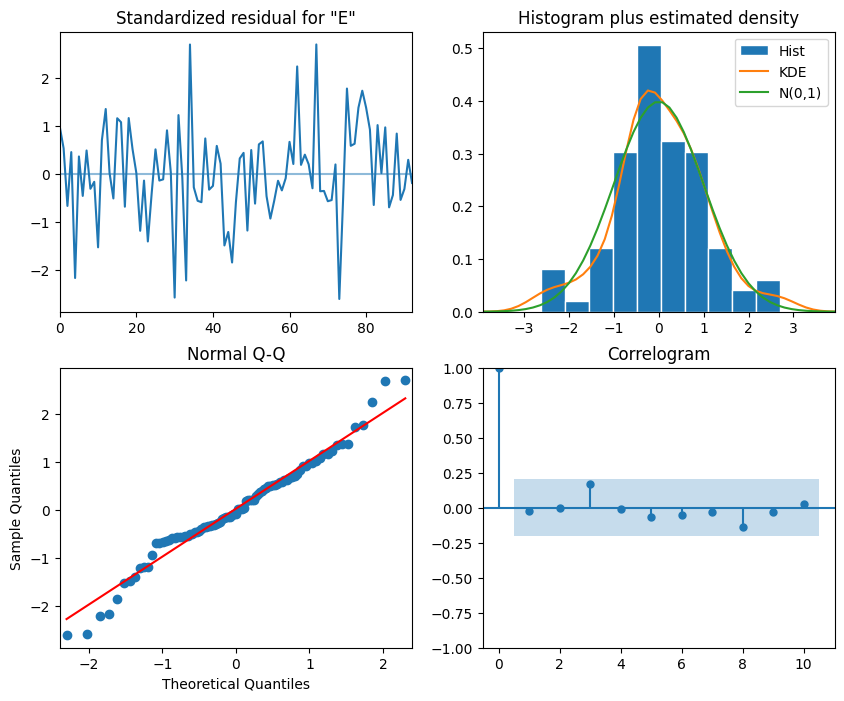

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model_arima110 = ARIMA(np.log(train), order=(1, 1, 0))
model_arima110_fit = model_arima110.fit()

print(model_arima110_fit.summary())

model_arima110_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  ELARG   No. Observations:                   94
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 260.679
Date:                Thu, 15 Jan 2026   AIC                           -515.358
Time:                        11:40:43   BIC                           -507.760
Sample:                             0   HQIC                          -512.290
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2974      0.298     -0.997      0.319      -0.882       0.287
ma.L1         -0.0822      0.280     -0.294      0.769      -0.631       0.466
sigma2         0.0002   2.76e-05      7.787      0.0

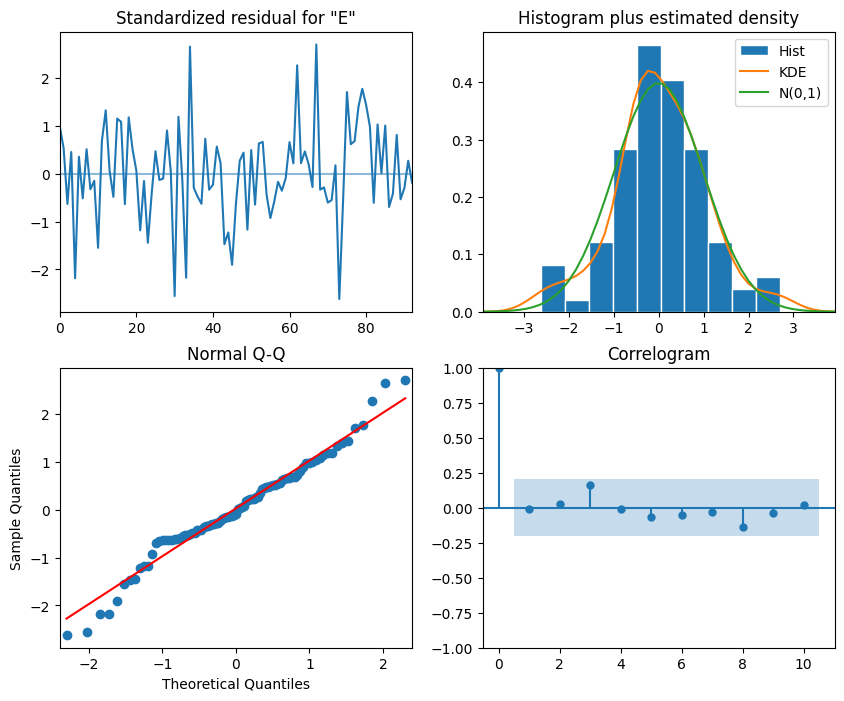

In [ ]:
model_arima111 = ARIMA(np.log(train), order=(1, 1, 1))
model_arima111_fit = model_arima111.fit()

print(model_arima111_fit.summary())

model_arima111_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  ELARG   No. Observations:                   93
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 260.603
Date:                Thu, 15 Jan 2026   AIC                           -515.205
Time:                        11:40:45   BIC                           -507.608
Sample:                             0   HQIC                          -512.138
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.221      0.825      -0.002       0.002
ar.L1         -0.3670      0.115     -3.186      0.001      -0.593      -0.141
sigma2         0.0002   2.74e-05      7.863      0.0

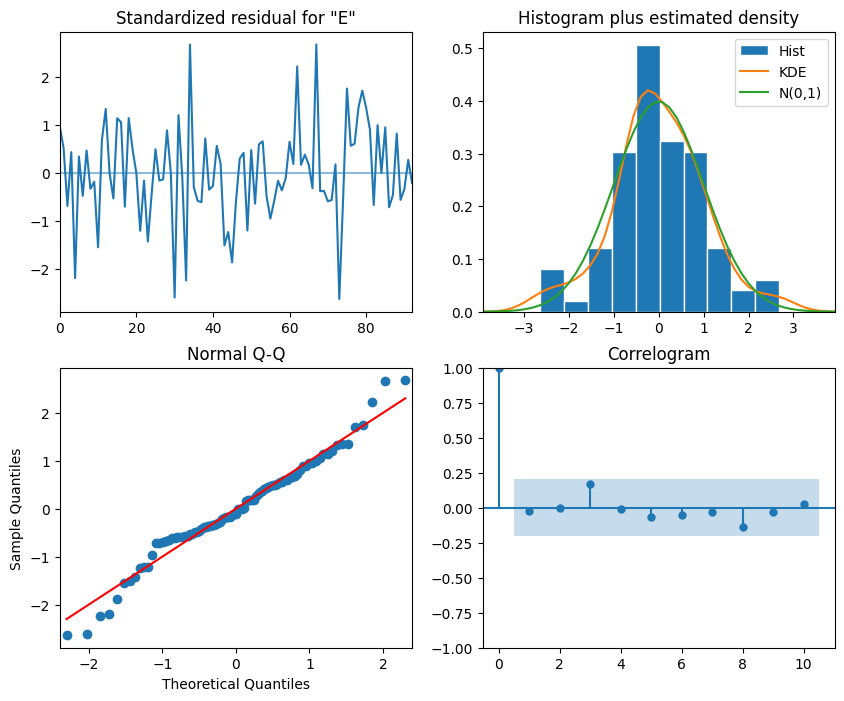

In [ ]:
model_arima100 = ARIMA(train_lr, order=(1, 0, 0))
model_arima100_fit = model_arima100.fit()

print(model_arima100_fit.summary())

model_arima100_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  ELARG   No. Observations:                   93
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 260.793
Date:                Thu, 15 Jan 2026   AIC                           -513.587
Time:                        11:40:51   BIC                           -503.456
Sample:                             0   HQIC                          -509.496
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.228      0.820      -0.002       0.002
ar.L1         -0.3904      0.116     -3.377      0.001      -0.617      -0.164
ar.L2         -0.0636      0.101     -0.627      0.5

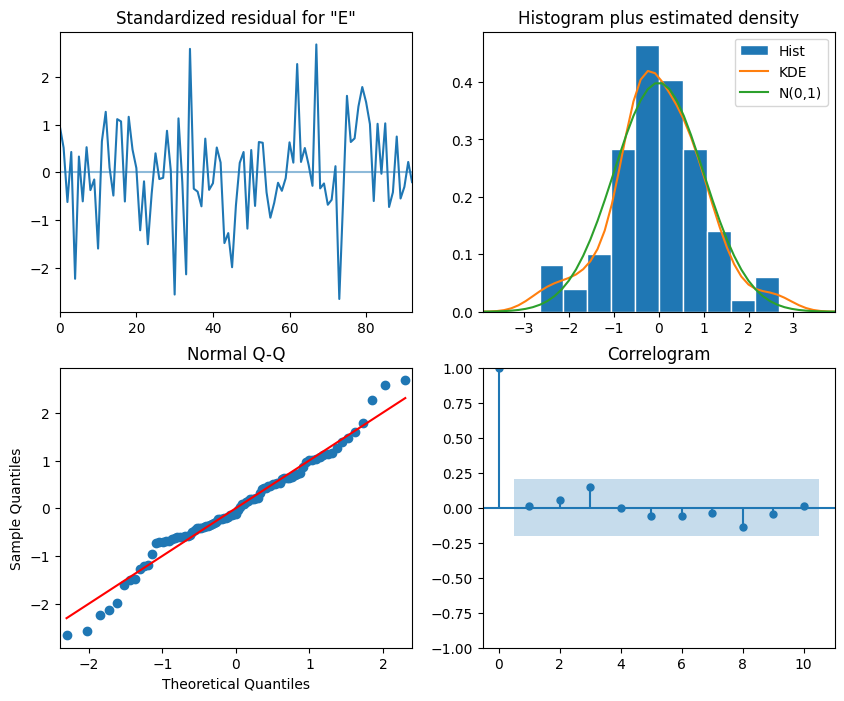

In [ ]:
model_arima200 = ARIMA(train_lr, order=(2, 0, 0))
model_arima200_fit = model_arima200.fit()

print(model_arima200_fit.summary())

model_arima200_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [ ]:
print("ARIMA(1,1,0) on train (AIC: %.3f, BIC: %.3f)" % (model_arima110_fit.aic, model_arima110_fit.bic))
print("ARIMA(1,1,1) on train (AIC: %.3f, BIC: %.3f)" % (model_arima111_fit.aic, model_arima111_fit.bic))
print("ARIMA(1,0,0) on train_lr (AIC: %.3f, BIC: %.3f)" % (model_arima100_fit.aic, model_arima100_fit.bic))
print("ARIMA(2,0,0) on train_lr (AIC: %.3f, BIC: %.3f)" % (model_arima200_fit.aic, model_arima200_fit.bic))

ARIMA(1,1,0) on train (AIC: -517.154, BIC: -512.089)
ARIMA(1,1,1) on train (AIC: -515.358, BIC: -507.760)
ARIMA(1,0,0) on train_lr (AIC: -515.205, BIC: -507.608)
ARIMA(2,0,0) on train_lr (AIC: -513.587, BIC: -503.456)


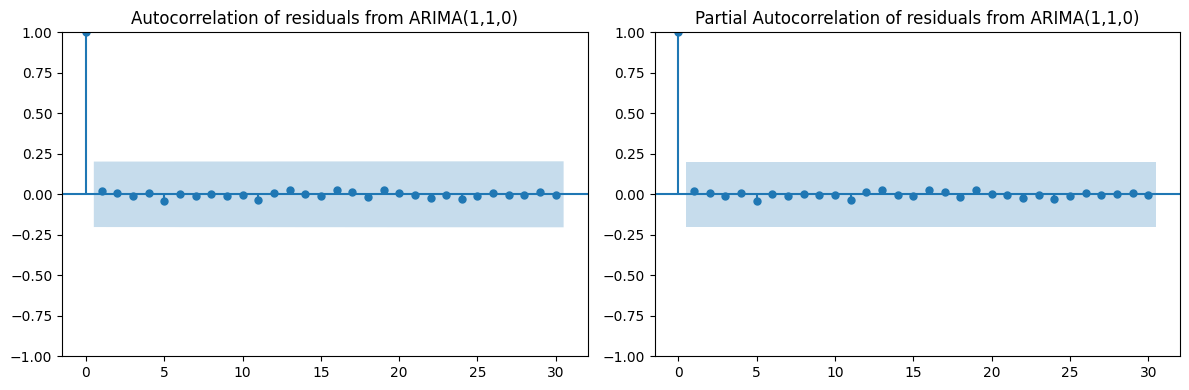

In [ ]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(fit_arima110_res, ax=ax[0], lags=30, title= 'Autocorrelation of residuals from ARIMA(1,1,0)' )
plot_pacf(fit_arima110_res, ax=ax[1], lags=30, title= 'Partial Autocorrelation of residuals from ARIMA(1,1,0)')
plt.tight_layout()
plt.show()

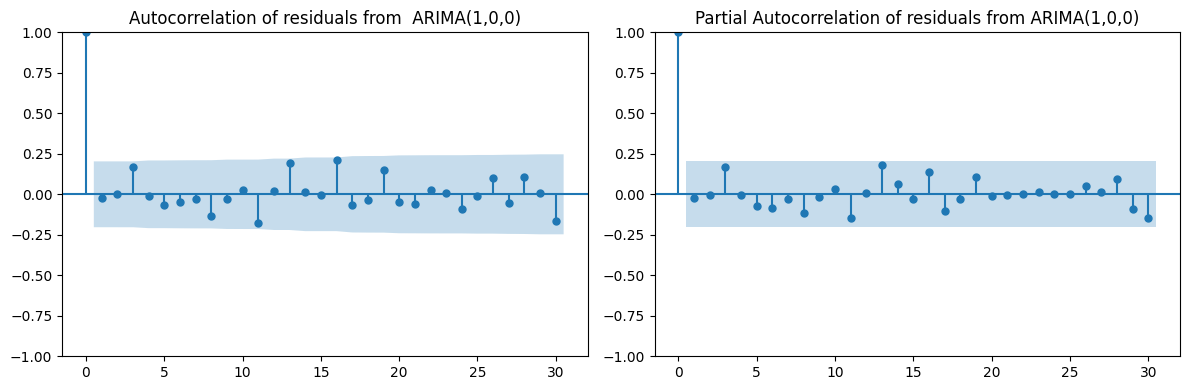

In [ ]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(fit_arima100_res, ax=ax[0], lags=30, title= 'Autocorrelation of residuals from  ARIMA(1,0,0)' )
plot_pacf(fit_arima100_res, ax=ax[1], lags=30, title= 'Partial Autocorrelation of residuals from ARIMA(1,0,0)')
plt.tight_layout()
plt.show()

In [ ]:
lb_serial_corr = model_arima110_fit.test_serial_correlation("ljungbox")

for i, (stat, p) in enumerate(zip(lb_serial_corr[0][0], lb_serial_corr[0][1])):
    print(f"Lag {i + 1}, test statistic = {stat:.3f} with p-value {p:.3f}")

Lag 1, test statistic = 0.053 with p-value 0.818
Lag 2, test statistic = 0.053 with p-value 0.974
Lag 3, test statistic = 2.813 with p-value 0.421
Lag 4, test statistic = 2.822 with p-value 0.588
Lag 5, test statistic = 3.275 with p-value 0.658
Lag 6, test statistic = 3.520 with p-value 0.741
Lag 7, test statistic = 3.605 with p-value 0.824
Lag 8, test statistic = 5.498 with p-value 0.703
Lag 9, test statistic = 5.588 with p-value 0.780
Lag 10, test statistic = 5.663 with p-value 0.843


In [ ]:
lb_serial_corr = model_arima100_fit.test_serial_correlation("ljungbox")

for i, (stat, p) in enumerate(zip(lb_serial_corr[0][0], lb_serial_corr[0][1])):
    print(f"Lag {i + 1}, test statistic = {stat:.3f} with p-value {p:.3f}")

Lag 1, test statistic = 0.052 with p-value 0.820
Lag 2, test statistic = 0.052 with p-value 0.975
Lag 3, test statistic = 2.813 with p-value 0.421
Lag 4, test statistic = 2.822 with p-value 0.588
Lag 5, test statistic = 3.275 with p-value 0.658
Lag 6, test statistic = 3.521 with p-value 0.741
Lag 7, test statistic = 3.606 with p-value 0.824
Lag 8, test statistic = 5.500 with p-value 0.703
Lag 9, test statistic = 5.590 with p-value 0.780
Lag 10, test statistic = 5.664 with p-value 0.843


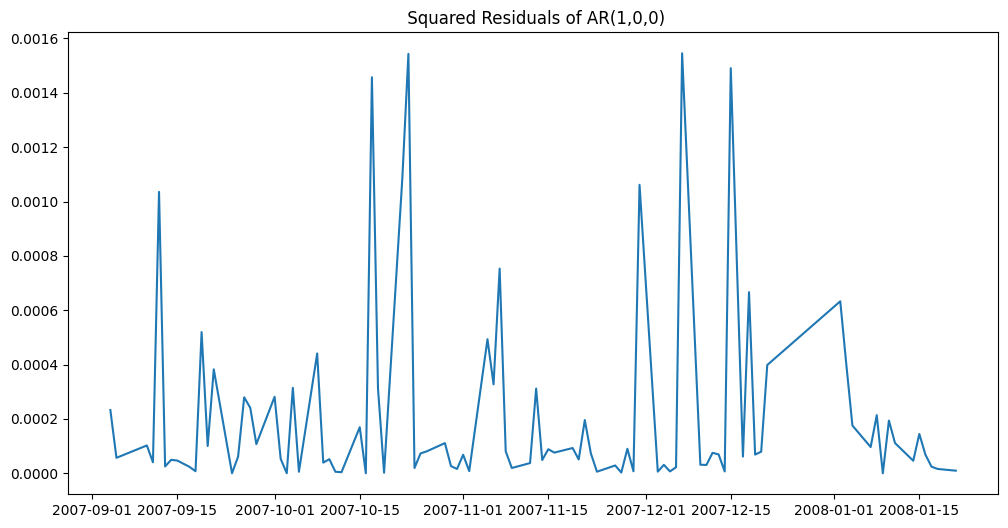

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(fit_arima100_res**2)
ax.set_title(' Squared Residuals of AR(1,0,0)')
plt.show()

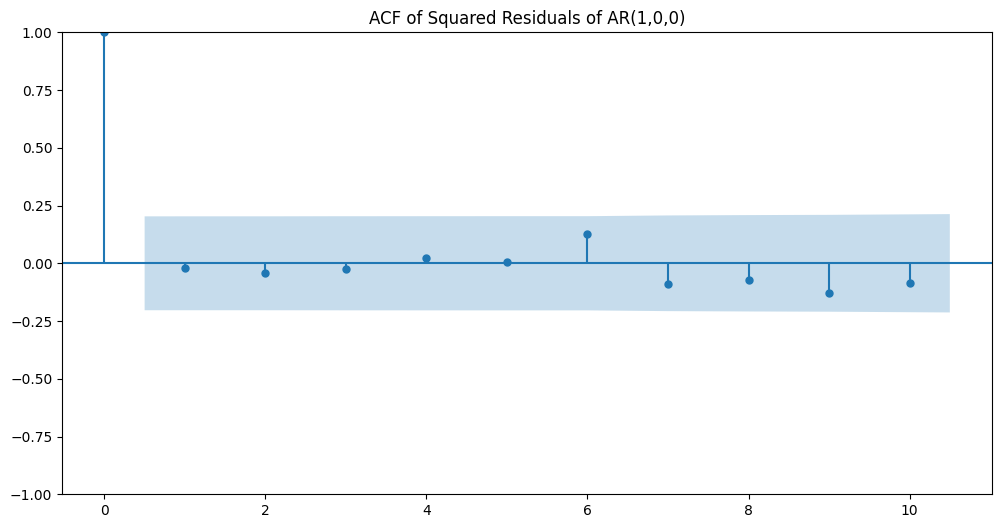

In [ ]:
fit_arima100_res = model_arima100_fit.resid.dropna()

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(fit_arima100_res**2, lags=10, ax=ax)
ax.set_title('ACF of Squared Residuals of AR(1,0,0)')
plt.show()

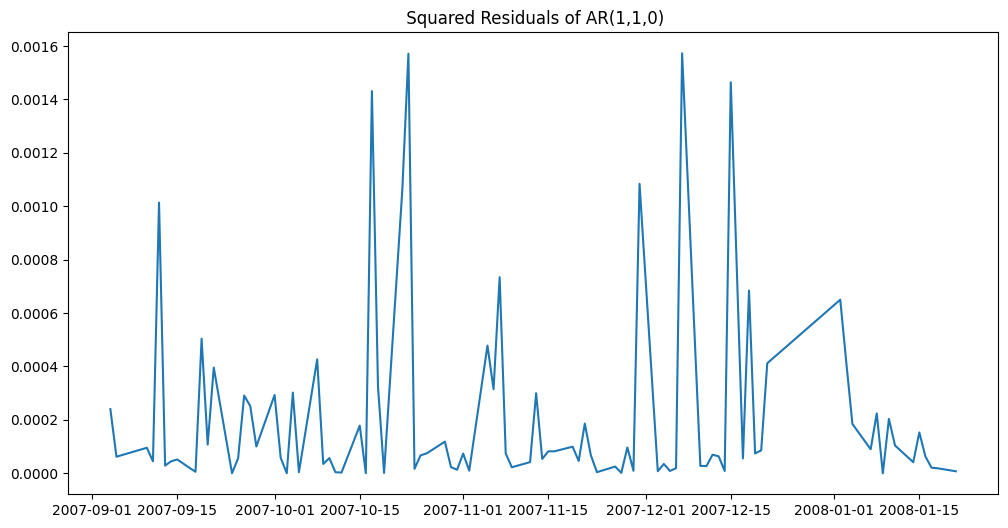

In [ ]:
cleaned_residuals = fit_arima110_res[1:]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cleaned_residuals.index, cleaned_residuals**2)
ax.set_title(' Squared Residuals of AR(1,1,0)')
plt.show()

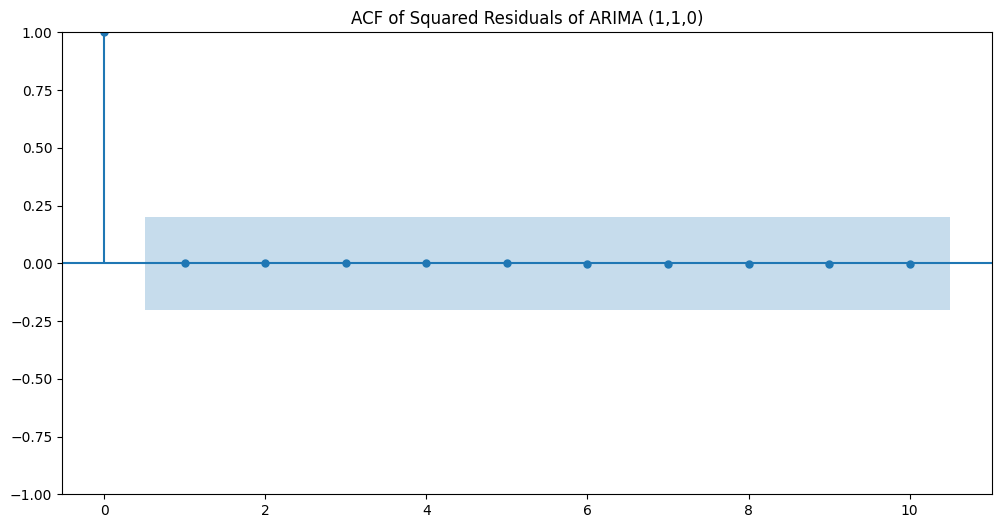

In [ ]:
fit_arima110_res = model_arima110_fit.resid.dropna()

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(fit_arima110_res**2, lags=10, ax=ax)
ax.set_title('ACF of Squared Residuals of ARIMA (1,1,0)')
plt.show()

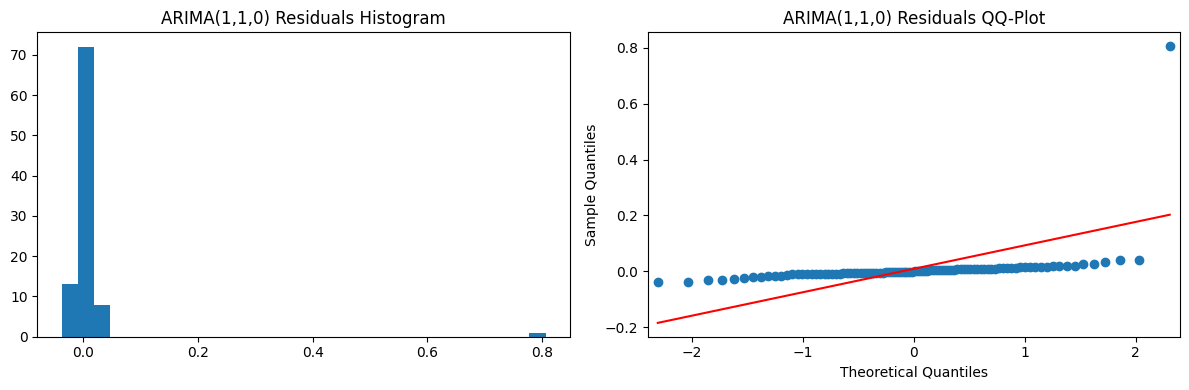

In [ ]:
from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(fit_arima110_res, bins=30)
ax[0].set_title("ARIMA(1,1,0) Residuals Histogram")

qqplot(fit_arima110_res, line='s', ax=ax[1])
ax[1].set_title("ARIMA(1,1,0) Residuals QQ-Plot")
plt.tight_layout()
plt.show()

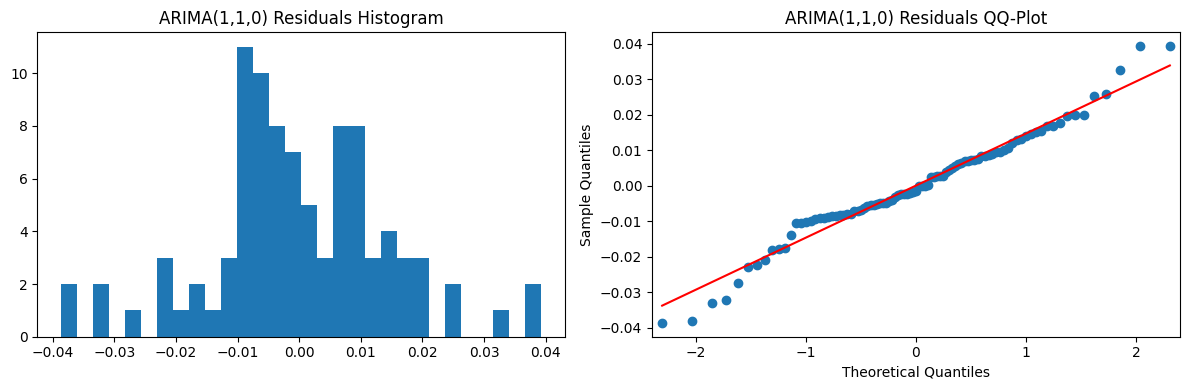

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(fit_arima100_res, bins=30)
ax[0].set_title("ARIMA(1,0,0) Residuals Histogram")

qqplot(fit_arima100_res, line='s', ax=ax[1])
ax[1].set_title("ARIMA(1,0,0) Residuals QQ-Plot")
plt.tight_layout()
plt.show()

# GARCH

In [ ]:
rescaled_residuals = fit_arima100_res * 100

model = arch_model(rescaled_residuals, mean='Constant', vol='GARCH', p=1, q=1, o=0, dist='t')
fit_GARCH100 = model.fit(disp='off')
print(fit_GARCH100.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -166.302
Distribution:      Standardized Student's t   AIC:                           342.604
Method:                  Maximum Likelihood   BIC:                           355.267
                                              No. Observations:                   93
Date:                      Thu, Jan 15 2026   Df Residuals:                       92
Time:                              11:41:05   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

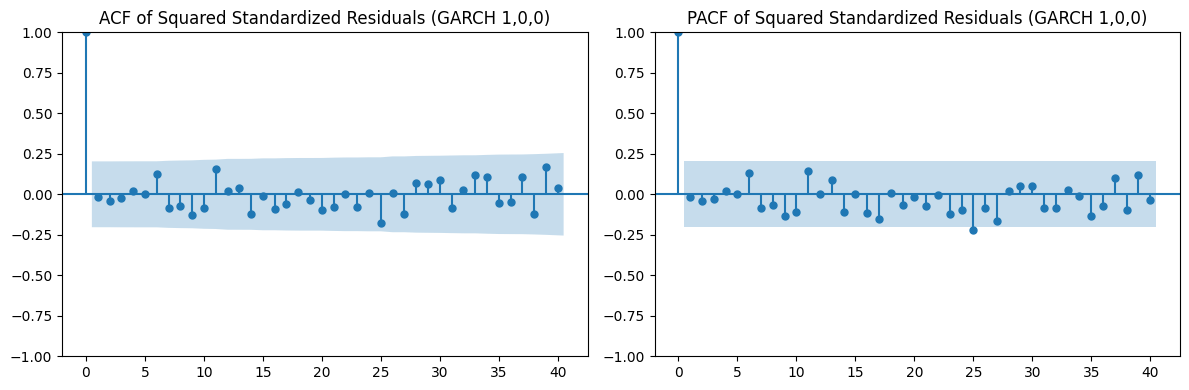

In [ ]:
fit_GARCH100_res = fit_GARCH100.std_resid

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(fit_GARCH100_res**2, lags=40, ax=ax[0], title ='ACF of Squared Standardized Residuals (GARCH 1,0,0)')
plot_pacf(fit_GARCH100_res**2, lags=40, ax=ax[1], title ='PACF of Squared Standardized Residuals (GARCH 1,0,0)')
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

std_resid_garch = fit_GARCH100.std_resid

lags_to_test = list(range(1, 11))
lungbox_results = acorr_ljungbox(std_resid_garch, lags=lags_to_test, return_df=True)

print()
for lag in lags_to_test:
    stat = lungbox_results.loc[lag, 'lb_stat']
    p_value = lungbox_results.loc[lag, 'lb_pvalue']
    print(f"Lag {lag}, test statistic = {stat:.3f} with p-value {p_value:.3f}")


Lag 1, test statistic = 0.050 with p-value 0.824
Lag 2, test statistic = 0.050 with p-value 0.975
Lag 3, test statistic = 2.814 with p-value 0.421
Lag 4, test statistic = 2.827 with p-value 0.587
Lag 5, test statistic = 3.275 with p-value 0.658
Lag 6, test statistic = 3.524 with p-value 0.741
Lag 7, test statistic = 3.607 with p-value 0.824
Lag 8, test statistic = 5.502 with p-value 0.703
Lag 9, test statistic = 5.593 with p-value 0.780
Lag 10, test statistic = 5.660 with p-value 0.843


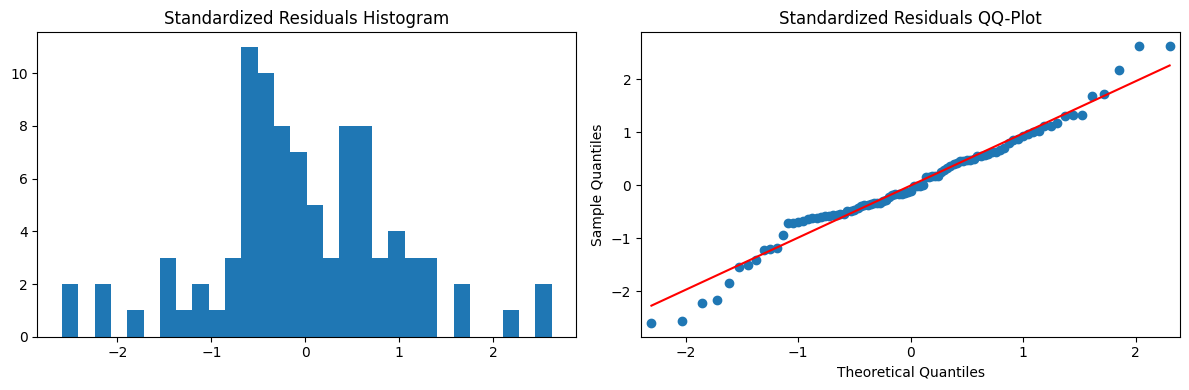

In [ ]:
from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(fit_GARCH100_res, bins=30)
ax[0].set_title("Standardized Residuals Histogram")

qqplot(fit_GARCH100_res, line='s', ax=ax[1])
ax[1].set_title("Standardized Residuals QQ-Plot")
plt.tight_layout()
plt.show()

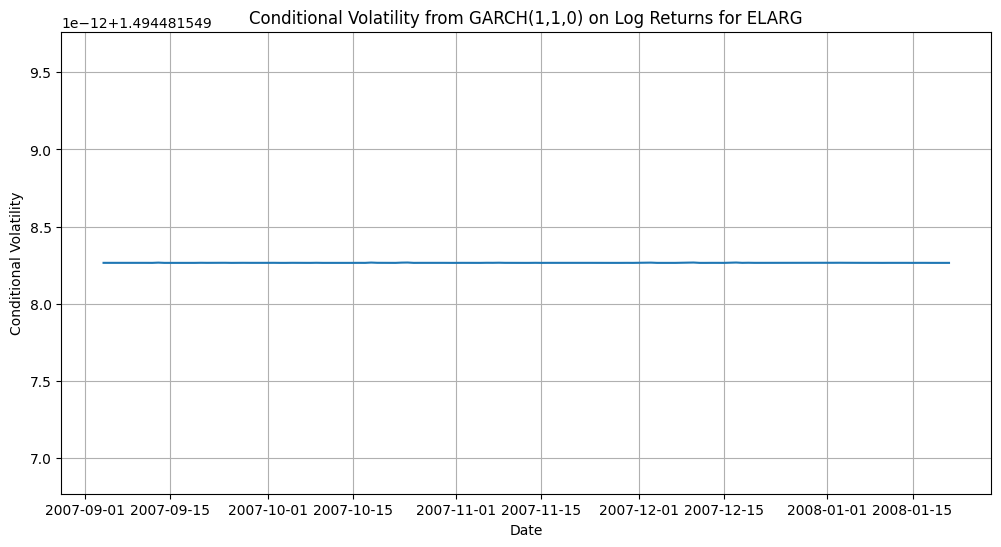

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(fit_GARCH100.conditional_volatility)
plt.title(f'Conditional Volatility from GARCH(1,1,0) on Log Returns for {dt.name}')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

In [ ]:
rescaled_residuals = fit_arima110_res * 100

model = arch_model(rescaled_residuals, mean='Constant', vol='GARCH', p=1, q=1, o=0, dist='t')
fit_GARCH110 = model.fit(disp='off')
print(fit_GARCH110.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -178.775
Distribution:      Standardized Student's t   AIC:                           367.551
Method:                  Maximum Likelihood   BIC:                           380.267
                                              No. Observations:                   94
Date:                      Thu, Jan 15 2026   Df Residuals:                       93
Time:                              11:41:10   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

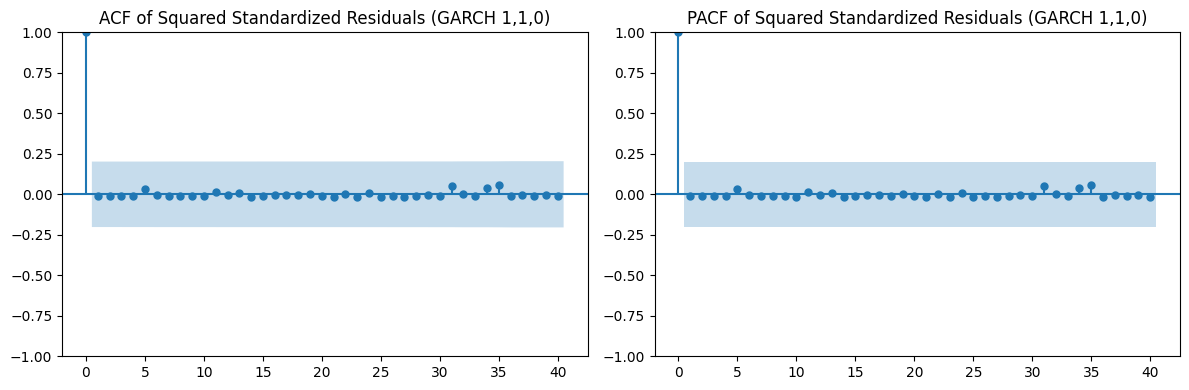

In [ ]:
fit_GARCH110_res = fit_GARCH110.std_resid

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(fit_GARCH110_res**2, lags=40, ax=ax[0], title ='ACF of Squared Standardized Residuals (GARCH 1,1,0)')
plot_pacf(fit_GARCH110_res**2, lags=40, ax=ax[1], title ='PACF of Squared Standardized Residuals (GARCH 1,1,0)')
plt.tight_layout()
plt.show()

In [ ]:
std_resid_garch = fit_GARCH110.std_resid

lags_to_test = list(range(1, 11))
lungbox_results = acorr_ljungbox(std_resid_garch, lags=lags_to_test, return_df=True)

print()
for lag in lags_to_test:
    stat = lungbox_results.loc[lag, 'lb_stat']
    p_value = lungbox_results.loc[lag, 'lb_pvalue']
    print(f"Lag {lag}, test statistic = {stat:.3f} with p-value {p_value:.3f}")


Lag 1, test statistic = 0.005 with p-value 0.942
Lag 2, test statistic = 0.034 with p-value 0.983
Lag 3, test statistic = 0.292 with p-value 0.962
Lag 4, test statistic = 0.344 with p-value 0.987
Lag 5, test statistic = 2.505 with p-value 0.776
Lag 6, test statistic = 2.509 with p-value 0.867
Lag 7, test statistic = 2.687 with p-value 0.912
Lag 8, test statistic = 2.864 with p-value 0.943
Lag 9, test statistic = 2.961 with p-value 0.966
Lag 10, test statistic = 2.966 with p-value 0.982


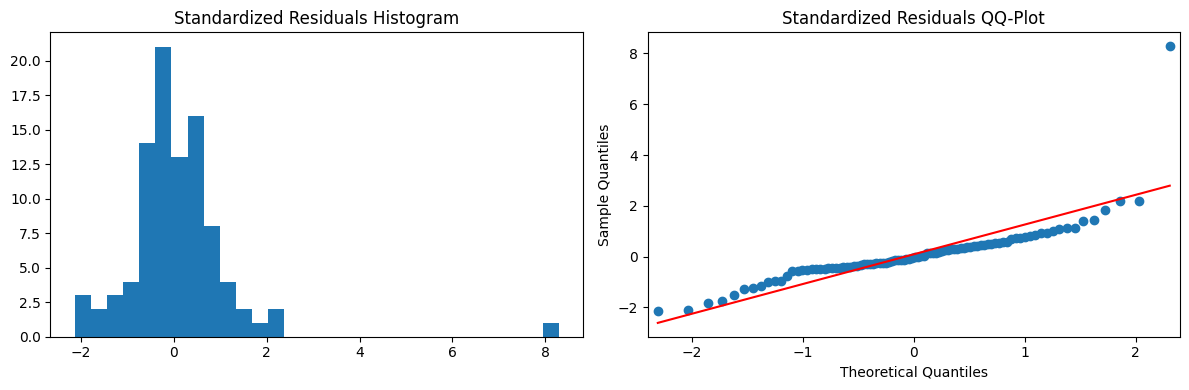

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(fit_GARCH110_res, bins=30)
ax[0].set_title("Standardized Residuals Histogram")

qqplot(fit_GARCH110_res, line='s', ax=ax[1])
ax[1].set_title("Standardized Residuals QQ-Plot")
plt.tight_layout()
plt.show()

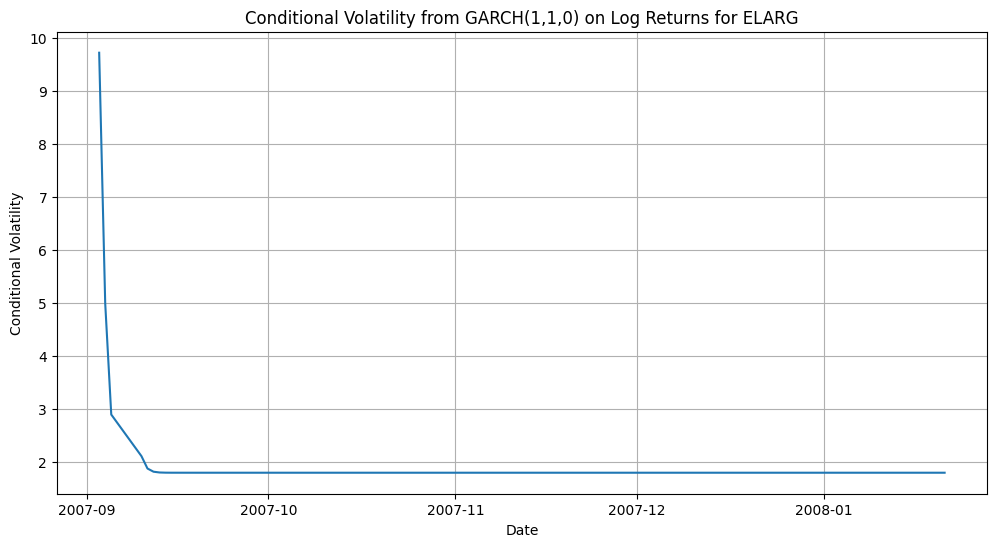

In [177]:
plt.figure(figsize=(12, 6))
plt.plot(fit_GARCH110.conditional_volatility)
plt.title(f'Conditional Volatility from GARCH(1,1,0) on Log Returns for {dt.name}')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

In [ ]:
forecast = model_arima110_fit.forecast(steps=10)
print("10-step Forecast")
print(forecast)

10-step Forecast
94     0.834500
95     0.833917
96     0.834130
97     0.834052
98     0.834081
99     0.834070
100    0.834074
101    0.834073
102    0.834073
103    0.834073
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
forecast = model_arima100_fit.forecast(steps=10)
print("10-step Forecast")
print(forecast)

10-step Forecast
93     0.001936
94    -0.000367
95     0.000478
96     0.000168
97     0.000282
98     0.000240
99     0.000255
100    0.000250
101    0.000252
102    0.000251
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


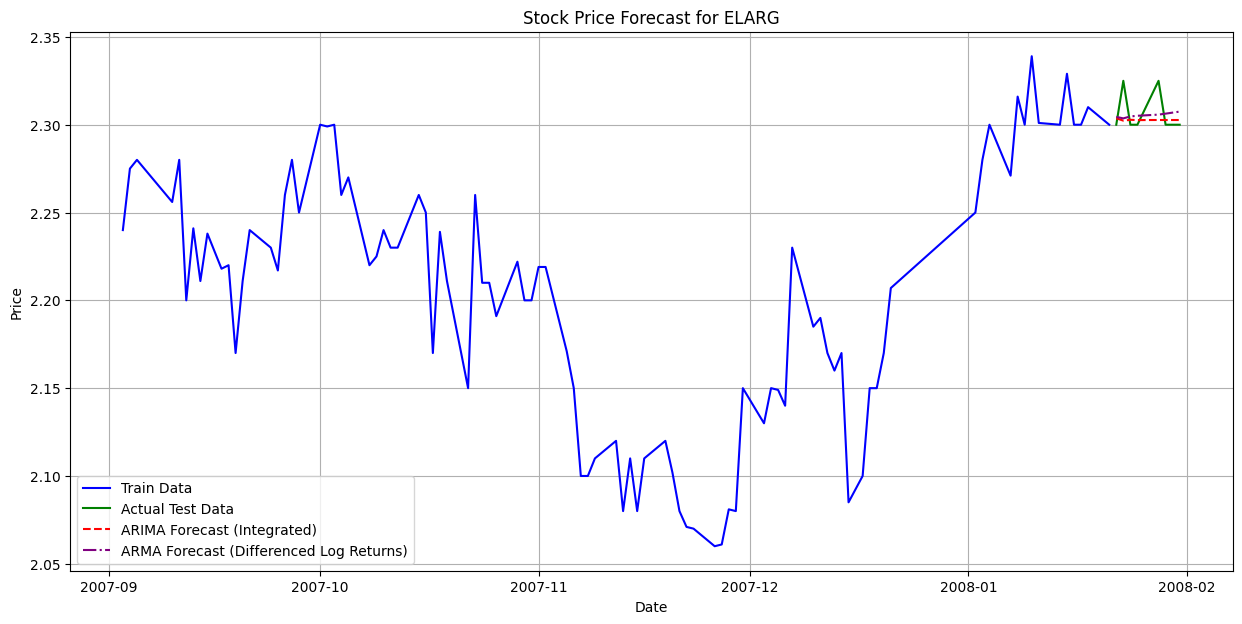

In [ ]:
forecast_steps = len(test.dropna())

arima_log_forecast = model_arima110_fit.forecast(steps=forecast_steps)
arima_price_forecast = pd.Series(np.exp(arima_log_forecast.values), index=test.dropna().index)


last_train_price = train.iloc[-1]
# Using model_arima100_fit which was fitted on train_lr (differenced log returns)
arma_lr_forecast = model_arima100_fit.forecast(steps=forecast_steps)
arma_lr_forecast = pd.Series(arma_lr_forecast.values, index=test.dropna().index)


arma_price_forecast = last_train_price * np.exp(arma_lr_forecast.cumsum())

plt.figure(figsize=(15, 7))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.dropna().index, test.dropna(), label='Actual Test Data', color='green')
plt.plot(arima_price_forecast.index, arima_price_forecast, label='ARIMA Forecast (Integrated)', color='red', linestyle='--')
plt.plot(arma_price_forecast.index, arma_price_forecast, label='ARMA Forecast (Differenced Log Returns)', color='purple', linestyle='-.')

plt.title(f'Stock Price Forecast for {dt.name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

actual_test_data = test.dropna()

# Calculate RMSE for ARIMA (Integrated) forecast
rmse_arima = np.sqrt(mean_squared_error(actual_test_data, arima_price_forecast))
print(f"RMSE for ARIMA (Integrated) Forecast: {rmse_arima:.4f}")

# Calculate RMSE for ARMA (Differenced Log Returns) forecast
rmse_arma = np.sqrt(mean_squared_error(actual_test_data, arma_price_forecast))
print(f"RMSE for ARMA (Differenced Log Returns) Forecast: {rmse_arma:.4f}")

RMSE for ARIMA (Integrated) Forecast: 0.0115
RMSE for ARMA (Differenced Log Returns) Forecast: 0.0114
